In [1]:
%matplotlib inline
import datetime
import numpy as np
import pathlib as pl
import pandas as pd
import geopandas as gpd
import sys
import xugrid

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as dates
import matplotlib.ticker as ticker

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import flopy
import flopy.plot.styles as styles

In [2]:
sys.path.append("../common")
from liss_settings import (
                            cx, cx_provider, 
                            extent, boxx, boxy, 
                            mf6_model_crs, 
                            set_title_string,  
                            fig_ext, transparent, 
                            get_modflow_coupling_tag, 
                            get_dflow_dtuser, 
                            get_dflow_grid_name,
                          )

In [3]:
figsize = (10.6, 5.95)
alpha = 0.5
basemap_kwds = {"attribution": False, "source": cx_provider, "zoom": 13}
progress_kwds = {"lw": 0.0, "fc": "cyan", "alpha": 0.25, "zorder": 10}
animation_ws = pl.Path("animations")
animation_ws.mkdir(exist_ok=True, parents=True)

#### Set unit conversion factors

In [4]:
d2sec = 24. * 60. * 60.
hrs2sec = 60. * 60. 
m2ft = 3.28081
cfd2cms = 1.0 / ((3.28082**3) * 86400.)

In [5]:
units = "mm"
conversion_factor = 1.0
if units == "mm":
    conversion_factor = 1000.0 / 3.28081
elif units == "in":
    conversion_factor = 12.0
head_units = "m"
head_conversion_factor = 1.0
if head_units == "m":
    head_conversion_factor = 1.0 / 3.28081
stage_units = head_units
stage_conversion_factor = 1.0
if stage_units == "ft":
    stage_conversion_factor = 3.28081
flux_units = units
if flux_units == "mm":
    flux_conversion_factor = 1000.0
elif flux_units == "in":
    flux_conversion_factor = 3.28081 * 12.


#### Set the MODFLOW coupling frequency

Change the `mf_couple_freq_hours` value. Only tested for multiple of the D-Flow FM DtUser variable. Will not work for `mf_couple_freq_hours` values greater than 24.

In [6]:
control_path = pl.Path("../dflow-fm/coarse/tides/base/FlowFM.mdu") # change this if using a different D-Flow FM control file
grid_name = get_dflow_grid_name(control_path)
print(grid_name)

LIS_modflow_bathy2_net


In [7]:
coastal_dtuser = get_dflow_dtuser(control_path)
print(coastal_dtuser)

300.0


In [8]:
mf_couple_freq_hours = 1.0  #Change this value to change the coupling frequency
mf_couple_freq = mf_couple_freq_hours * hrs2sec
coastal_per_mf = int(mf_couple_freq / coastal_dtuser)
mf_output_sample = int(24. / mf_couple_freq_hours)

In [9]:
print(
    f"MODFLOW coupling frequency {mf_couple_freq_hours} hours\n" +
    f"MODFLOW coupled to the coastal every {coastal_per_mf} output time step ({coastal_dtuser} sec.)\n" +
    f"MODFLOW output sampling frequency {mf_output_sample}"
) 

MODFLOW coupling frequency 1.0 hours
MODFLOW coupled to the coastal every 12 output time step (300.0 sec.)
MODFLOW output sampling frequency 24


In [10]:
mf_tag = get_modflow_coupling_tag(mf_couple_freq_hours)
print(f"MODFLOW coupling tag: {mf_tag}")

MODFLOW coupling tag: 01.00H


#### Coastal model results (used for the calendar times)

In [11]:
full_results_ds = xugrid.open_dataset("../dflow-fm/coarse/tides/run/output/FlowFM_map.nc")
full_results_ds

<xarray.Dataset> Size: 3GB
Dimensions:                      (mesh2d_nNodes: 4917, mesh2d_nEdges: 13244,
                                  mesh2d_nFaces: 8323,
                                  mesh2d_nMax_face_nodes: 4, time: 2161)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 39kB ...
    mesh2d_node_y                (mesh2d_nNodes) float64 39kB ...
    mesh2d_edge_x                (mesh2d_nEdges) float64 106kB ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 106kB ...
    mesh2d_face_x                (mesh2d_nFaces) float64 67kB ...
    mesh2d_face_y                (mesh2d_nFaces) float64 67kB ...
  * time                         (time) datetime64[ns] 17kB 2010-01-01 ... 20...
  * mesh2d_nEdges                (mesh2d_nEdges) int64 106kB 0 1 ... 13242 13243
  * mesh2d_nFaces                (mesh2d_nFaces) int64 67kB 0 1 2 ... 8321 8322
  * mesh2d_nNodes                (mesh2d_nNodes) int64 39kB 0 1 2 ... 4915 4916
Dimensions without coordinates: mesh2d_nMax_face_nodes
Data variables: (12/23)
    projected_coordinate_system  int32 4B ...
    mesh2d_node_z                (mesh2d_nNodes) float64 39kB ...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 266kB ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 266kB ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 106kB ...
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 67kB ...
    ...                           ...
    mesh2d_q1                    (time, mesh2d_nEdges) float64 229MB ...
    mesh2d_viu                   (time, mesh2d_nEdges) float64 229MB ...
    mesh2d_diu                   (time, mesh2d_nEdges) float64 229MB ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 144MB ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 144MB ...
    mesh2d_czu                   (time, mesh2d_nEdges) float64 229MB ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         D-Flow FM 1.2.123.69078M. Model:
    history:        Created on 2025-07-03T09:23:56-0400, D-Flow FM
    date_created:   2025-07-03T09:23:56-0400
    date_modified:  2025-07-03T09:23:56-0400
    Conventions:    CF-1.8 UGRID-1.0 Deltares-0.10

#### Extract subset of coastal model for plotting 

In [12]:
results_ds = full_results_ds

In [13]:
coastal_gdf = results_ds["mesh2d_nFaces"].ugrid.to_geodataframe(name="cell")
coastal_gdf["stage"] = np.zeros((results_ds["mesh2d_nFaces"].values.shape[0]), dtype=float)
coastal_gdf.set_crs(32618, inplace=True)

,cell,mesh2d_face_x,mesh2d_face_y,geometry,stage
mesh2d_nFaces,,,,,
0,0,797792.521183,4.586474e+06,"POLYGON ((796131.574 4587170.597, 797777.440 4...",0.0
1,1,797860.277210,4.587935e+06,"POLYGON ((796131.574 4587170.597, 799510.824 4...",0.0
2,2,796310.449179,4.585497e+06,"POLYGON ((795089.014 4584339.408, 797777.440 4...",0.0
3,3,799141.332451,4.585475e+06,"POLYGON ((797777.440 4584672.393, 800555.306 4...",0.0
4,4,796489.440234,4.584052e+06,"POLYGON ((795089.014 4584339.408, 796588.120 4...",0.0
...,...,...,...,...,...
8318,8318,580457.554636,4.524681e+06,"POLYGON ((579415.246 4525870.803, 580504.460 4...",0.0
8319,8319,580388.824822,4.526572e+06,"POLYGON ((579415.246 4525870.803, 581410.744 4...",0.0
8320,8320,581328.842310,4.527298e+06,"POLYGON ((580038.350 4527719.397, 581410.744 4...",0.0


In [14]:
cell_areas = coastal_gdf.area.values
cell_areas

array([4092123.40410018, 4435917.86112992, 3632142.04424176, ...,
       2241931.34166178, 1148954.06401034, 1414663.20704572])

In [15]:
time_str = results_ds["time"].values
time_str, time_str[-1]

(array(['2010-01-01T00:00:00.000000000', '2010-01-01T01:00:00.000000000',
        '2010-01-01T02:00:00.000000000', ...,
        '2010-03-31T22:00:00.000000000', '2010-03-31T23:00:00.000000000',
        '2010-04-01T00:00:00.000000000'], dtype='datetime64[ns]'),
 numpy.datetime64('2010-04-01T00:00:00.000000000'))

In [16]:
output_freq = int(np.timedelta64(1, "D") / (time_str[1] - time_str[0]))
time_index = np.arange(0, time_str.shape[0], output_freq)
time_index.shape, time_index[1:]

((91,),
 array([  24,   48,   72,   96,  120,  144,  168,  192,  216,  240,  264,
         288,  312,  336,  360,  384,  408,  432,  456,  480,  504,  528,
         552,  576,  600,  624,  648,  672,  696,  720,  744,  768,  792,
         816,  840,  864,  888,  912,  936,  960,  984, 1008, 1032, 1056,
        1080, 1104, 1128, 1152, 1176, 1200, 1224, 1248, 1272, 1296, 1320,
        1344, 1368, 1392, 1416, 1440, 1464, 1488, 1512, 1536, 1560, 1584,
        1608, 1632, 1656, 1680, 1704, 1728, 1752, 1776, 1800, 1824, 1848,
        1872, 1896, 1920, 1944, 1968, 1992, 2016, 2040, 2064, 2088, 2112,
        2136, 2160]))

In [17]:
time_mf = time_str[time_index]
print(time_mf.shape, time_mf)

(91,) ['2010-01-01T00:00:00.000000000' '2010-01-02T00:00:00.000000000'
 '2010-01-03T00:00:00.000000000' '2010-01-04T00:00:00.000000000'
 '2010-01-05T00:00:00.000000000' '2010-01-06T00:00:00.000000000'
 '2010-01-07T00:00:00.000000000' '2010-01-08T00:00:00.000000000'
 '2010-01-09T00:00:00.000000000' '2010-01-10T00:00:00.000000000'
 '2010-01-11T00:00:00.000000000' '2010-01-12T00:00:00.000000000'
 '2010-01-13T00:00:00.000000000' '2010-01-14T00:00:00.000000000'
 '2010-01-15T00:00:00.000000000' '2010-01-16T00:00:00.000000000'
 '2010-01-17T00:00:00.000000000' '2010-01-18T00:00:00.000000000'
 '2010-01-19T00:00:00.000000000' '2010-01-20T00:00:00.000000000'
 '2010-01-21T00:00:00.000000000' '2010-01-22T00:00:00.000000000'
 '2010-01-23T00:00:00.000000000' '2010-01-24T00:00:00.000000000'
 '2010-01-25T00:00:00.000000000' '2010-01-26T00:00:00.000000000'
 '2010-01-27T00:00:00.000000000' '2010-01-28T00:00:00.000000000'
 '2010-01-29T00:00:00.000000000' '2010-01-30T00:00:00.000000000'
 '2010-01-31T00:00:

In [18]:
gp_gpd = gpd.read_file("../modflow/gis/greenpoint_onshore_offshore_utm18n.shp")

#### Load the MODFLOW model

In [22]:
mf_run_path = pl.Path(f"../modflow/greenport_chd/run_{mf_tag}/")
mf_npz_path = mf_run_path

In [23]:
sim = flopy.mf6.MFSimulation.load(sim_ws=mf_run_path)
gwf = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package oc...
    loading package wel...
    loading package chd...
    loading package chd...
    loading package drn...
    loading package ghb...
    loading package buy...
    loading package wel...
    loading package obs...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package mst...
    loading package ssm...
    loading package fmi...
    loading package oc...
  loading exchange package gwf-gwt_exg_0...
  loading solution package gwf...
  loading solution package gwt...


In [24]:
hobj = gwf.output.head()

In [25]:
totimes = hobj.get_times()
print(f"{len(totimes)}\n{totimes}")

90
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0]


In [26]:
bobj = gwf.output.budget()

In [27]:
bobj.get_unique_record_names()

[b'          STO-SS',
 b'          STO-SY',
 b'    FLOW-JA-FACE',
 b'             WEL',
 b'             DRN',
 b'             GHB',
 b'            RCHA',
 b'             CHD']

#### Calculate the mean recharge

In [28]:
mean_recharge = []
for totim in totimes:
    rQ = bobj.get_data(text="RCH", totim=totim)[0]
    q = rQ["q"]
    idx = q > 0.
    mean_recharge.append(q[idx].mean())
    
mean_recharge = np.array(mean_recharge) * (conversion_factor / (500. * 500.))

In [29]:
mean_recharge.shape, mean_recharge.max()

((90,), 57.26131817782966)

In [30]:
df = pd.DataFrame(data=mean_recharge)
df.set_index(time_mf[:mean_recharge.shape[0]],inplace=True)

In [31]:
df

,0
2010-01-01,0.682168
2010-01-02,0.165404
2010-01-03,0.165404
2010-01-04,0.165404
2010-01-05,0.165404
...,...
2010-03-27,0.165404
2010-03-28,0.165404
2010-03-29,47.970000
2010-03-30,57.261318


#### Load ghb shapefile

In [32]:
mf6_gpd = gpd.read_file("../modflow/gis/greenpoint_ghb_4456.shp")
mf6_gpd["head_difference"] = np.zeros((mf6_gpd.shape[0]), dtype=float)
mf6_gpd

,layer,row,column,bhead,cond,iface,boundname,ghb_no,ID,geometry,head_difference
0,0,26,0,0.0,24999.999994,0,sound,0,1483,"POLYGON ((2436580.557 321004.352, 2437056.085 ...",0.0
1,0,27,0,0.0,25000.000000,0,sound,1,1540,"POLYGON ((2436735.066 320528.824, 2437210.594 ...",0.0
2,0,28,0,0.0,24999.999994,0,sound,2,1597,"POLYGON ((2436889.574 320053.295, 2437365.102 ...",0.0
3,0,29,0,0.0,24231.956659,0,sound,3,1654,"POLYGON ((2437044.083 319577.767, 2437519.611 ...",0.0
4,0,25,1,0.0,25000.000006,0,sound,4,1427,"POLYGON ((2436901.577 321634.389, 2437377.105 ...",0.0
...,...,...,...,...,...,...,...,...,...,...,...
730,0,14,56,0.0,22494.219708,0,peconic,730,855,"POLYGON ((2461356.038 335363.167, 2461831.566 ...",0.0
731,0,15,56,0.0,25000.000006,0,peconic,731,912,"POLYGON ((2461510.546 334887.639, 2461986.074 ...",0.0
732,0,16,56,0.0,24999.999994,0,peconic,732,969,"POLYGON ((2461665.055 334412.110, 2462140.583 ...",0.0
733,0,17,56,0.0,25000.000000,0,peconic,733,1026,"POLYGON ((2461819.563 333936.582, 2462295.091 ...",0.0


In [33]:
mf6_gpd.crs

<Projected CRS: EPSG:4456>
Name: NAD27 / New York Long Island
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: New York CS27 Long Island zone
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1927
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

#### Load active grid shapefile

In [34]:
mf6_grid_gpd = gpd.read_file("../modflow/gis/greenpoint_onshore_offshore_4456.shp")
mf6_grid_gpd

,ID_1,layer,row,column,bhead,cond,iface,boundname,ghb_no,ID_2,onshore,geometry
0,99,0.0,1.0,41.0,0.0,25000.000000,0.0,sound,213.0,99.0,1,"POLYGON ((2452690.031 339381.915, 2452844.540 ..."
1,100,0.0,1.0,42.0,0.0,24999.999994,0.0,sound,218.0,100.0,1,"POLYGON ((2453165.560 339536.424, 2453320.068 ..."
2,101,0.0,1.0,43.0,0.0,25000.000006,0.0,sound,222.0,101.0,1,"POLYGON ((2453641.088 339690.932, 2453795.596 ..."
3,102,0.0,1.0,44.0,0.0,25000.000000,0.0,sound,226.0,102.0,1,"POLYGON ((2454116.616 339845.441, 2454271.125 ..."
4,103,0.0,1.0,45.0,0.0,25000.000000,0.0,sound,230.0,103.0,1,"POLYGON ((2454592.145 339999.949, 2454746.653 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1450,2412,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,onshore,-999.0,-999.0,0,"POLYGON ((2447136.673 316022.544, 2447612.202 ..."
1451,2467,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,onshore,-999.0,-999.0,0,"POLYGON ((2446815.654 315392.508, 2446970.162 ..."
1452,2469,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,onshore,-999.0,-999.0,0,"POLYGON ((2447766.710 315701.525, 2447921.219 ..."
1453,2527,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,onshore,-999.0,-999.0,0,"POLYGON ((2448075.727 314750.468, 2447921.219 ..."


#### Set the crs for the MODFLOW model

In [35]:
gwf.modelgrid.crs = mf6_gpd.crs

#### Load ghb data calculated using coastal model results

In [36]:
ghb_elev = np.load(f"{mf_npz_path}/ghb_elev.npz")
ghb_elev

NpzFile '..\\modflow\\greenport_chd\\run_01.00H/ghb_elev.npz' with keys: 0, 1, 2, 3, 4...

In [37]:
ghb_cond = np.load(f"{mf_npz_path}/ghb_cond.npz")
ghb_cond

NpzFile '..\\modflow\\greenport_chd\\run_01.00H/ghb_cond.npz' with keys: 0, 1, 2, 3, 4...

In [38]:
qext_elev = np.load(f"{mf_npz_path}/qext.npz")
qext_elev

NpzFile '..\\modflow\\greenport_chd\\run_01.00H/qext.npz' with keys: 0, 1, 2, 3, 4...

In [39]:
qsize, qmin, qmax = 0, 1e30, -1e30
for key, value in qext_elev.items():
    qsize = value.shape[0]
    qmin = min(qmin, np.nanmin(value))
    qmax = max(qmax, np.nanmax(value))
qmin *= 3.28081 * 12.0
qmax *= 3.28081 * 12.0
qsize, qmin, qmax

(8323, -53.200298418280575, 56.06363192498439)

In [40]:
qmin, qmax = -8.0, 8.0

In [41]:
qvalue = np.full(qsize, np.nan, dtype=float)

In [42]:
time_keys = ghb_elev.files
sampled_time_keys = time_keys[mf_output_sample-1::mf_output_sample]
print(
    len(time_keys),
    len(sampled_time_keys), 
    sampled_time_keys
)

2160 90 ['23', '47', '71', '95', '119', '143', '167', '191', '215', '239', '263', '287', '311', '335', '359', '383', '407', '431', '455', '479', '503', '527', '551', '575', '599', '623', '647', '671', '695', '719', '743', '767', '791', '815', '839', '863', '887', '911', '935', '959', '983', '1007', '1031', '1055', '1079', '1103', '1127', '1151', '1175', '1199', '1223', '1247', '1271', '1295', '1319', '1343', '1367', '1391', '1415', '1439', '1463', '1487', '1511', '1535', '1559', '1583', '1607', '1631', '1655', '1679', '1703', '1727', '1751', '1775', '1799', '1823', '1847', '1871', '1895', '1919', '1943', '1967', '1991', '2015', '2039', '2063', '2087', '2111', '2135', '2159']


In [43]:
v = hobj.get_data(totim=1.)[0]
v[v == 1.e30] = 0.
v.min(), v.max(), v.mean()

(-1.777894135645728, 2.9813656683011986, 0.1862938398416488)

In [44]:
gwf.modelgrid.crs

<Projected CRS: EPSG:4456>
Name: NAD27 / New York Long Island
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: New York CS27 Long Island zone
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1927
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

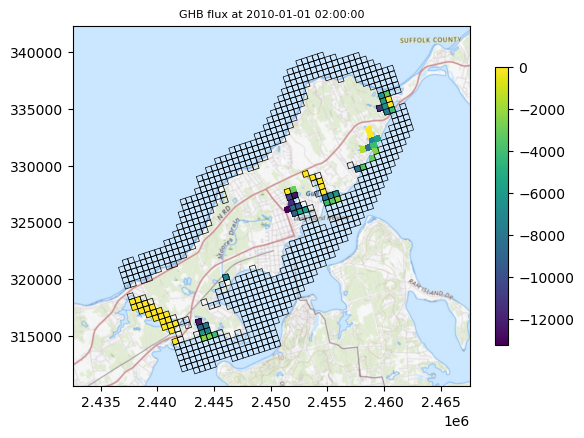

In [45]:
totim = 1.0
coastal_idx = int(totim) + 1
title_str = set_title_string(time_str[coastal_idx])  
mm = flopy.plot.PlotMapView(model=gwf)
# hc = mm.plot_array(hobj.get_data(totim=1.0))
hc = mm.plot_array(bobj.get_data(text="GHB", totim=totim, full3D=True)[0])
mf6_gpd.plot(ax=mm.ax, lw=0.5, ec="black", color="none")
plt.colorbar(hc, ax=mm.ax, shrink=0.75)
cx.add_basemap(mm.ax, crs=mf6_gpd.crs, **basemap_kwds)
mm.ax.set_title(f"GHB flux at {title_str}", size=8);

In [46]:
mosaic_list = [
    ["c","c","c","c"],
    ["a","a","b","b"],
    ["a","a","b","b"],
    ["a","a","b","b"],
    ["a","a","b","b"],
    ]

In [47]:
if units == "in":
    head_levels = [1, 2, 3]
    head_min, head_max = -1, 5
    stage_min, stage_max = -3, 3
    rch_min, rch_max = 0, 3
    flux_min, flux_max = -1, 1
elif units == "mm":
    head_levels = [0.25, 0.5, 0.75, 1.0]
    head_min, head_max = -0.25, 2
    stage_min, stage_max = -1, 1
    rch_min, rch_max = 0, 100
    flux_min, flux_max = -25, 25


#### MODFLOW 6 results

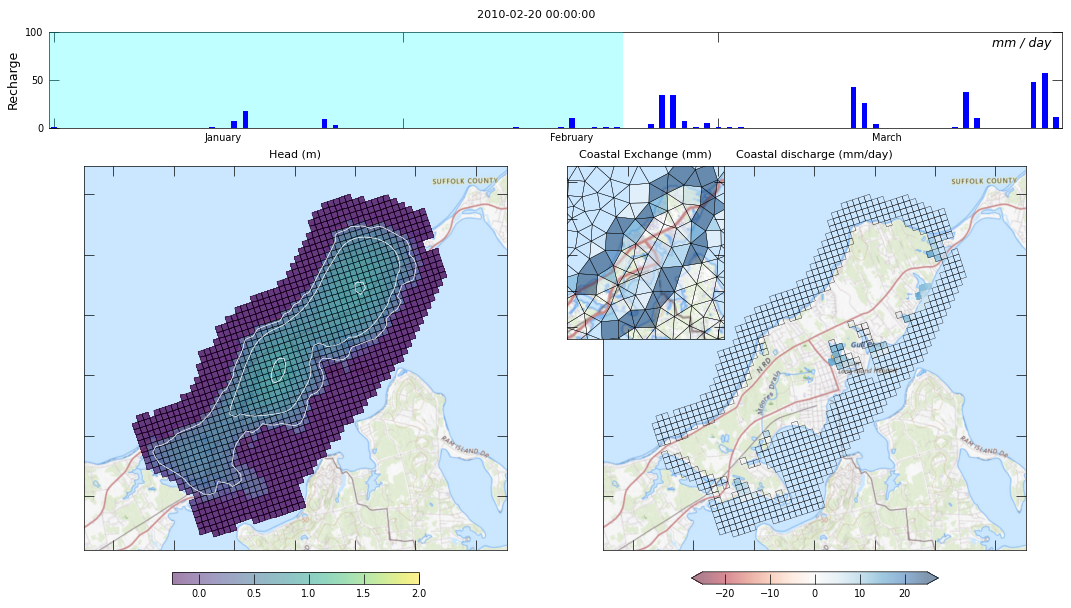

In [49]:
totim = 50
npz_idx = sampled_time_keys[totim]
with styles.USGSMap():
    fig, axd = plt.subplot_mosaic(
    mosaic_list,
    layout="constrained", 
    figsize=figsize,
    )    

    ax = axd["c"]
    ax.set_xlim(-0.5,mean_recharge.shape[0]-.5)
    ax.set_ylim(rch_min, rch_max)

    df.plot(kind="bar", ax=ax, legend=False, zorder=111, color="blue")
    fb = ax.fill_between([-0.5, totim+0.5], rch_max, **progress_kwds)

    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%B'))
    
    # Remove the tick lines
    ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment('center')

    ax.set_ylabel("Recharge")
    styles.add_text(ax, text=f"{units} / day", x=0.99, y=0.95, bold=False, va="top", ha="right")
    
    title_str = set_title_string(time_mf[int(totim)])  
    fig.suptitle(title_str, fontsize=8)

    h = hobj.get_data(totim=totim)
    h[h < 1e29] *= head_conversion_factor
    q = bobj.get_data(text="GHB", totim=totim, full3D=True)[0]
    q[q == 0.0] = np.nan   
    q *= conversion_factor / (500. * 500.)
    
    ax = axd["a"]
    mm0 = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    hc = mm0.plot_array(h, alpha=alpha, vmin=head_min, vmax=head_max)
    mf6_grid_gpd.plot(ax=ax, lw=0.25, ec="black", color="none")
    ca = mm0.contour_array(h, levels=head_levels, colors="white", linewidths=0.5)
    plt.colorbar(hc, ax=ax, shrink=0.5, orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Head ({head_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    

    ax = axd["b"]
    mm1 = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    ghbq = mm1.plot_array(-q, alpha=alpha, cmap="RdBu", vmin=flux_min , vmax=flux_max)
    mf6_gpd.plot(ax=ax, lw=0.25, ec="black", color="none")
    plt.colorbar(ghbq, ax=ax, shrink=0.5, extend="both", orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Coastal discharge ({units}/day)", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # coastal model inset
    ax_ins = axd["b"].inset_axes(
        [-0.125, 0.55, 0.45, 0.45],
        xticklabels=[], 
        yticklabels=[],
    )
    wdp = full_results_ds["mesh2d_s1"].isel(time=time_index[totim]).ugrid.plot(animated=True, ax=ax_ins, cmap="RdBu", vmin=flux_min, vmax=flux_max, lw=0.0, alpha=alpha, add_colorbar=False)
    gdfp = coastal_gdf.plot(color="black", fc="none", lw=0.25, ax=ax_ins)

    qvalue = qext_elev[str(npz_idx)]
    qvalue *= flux_conversion_factor * 86400. / cell_areas
    qvalue[qvalue == 0.0] = np.nan
    wdp.set_array(qvalue)

    ax_ins.set_xlim(extent[:2])
    ax_ins.set_ylim(extent[2:])
    cx.add_basemap(ax_ins, crs=gp_gpd.crs, attribution=False, source=cx_provider, zoom=11)

    ax_ins.set_title(f"Coastal Exchange ({flux_units})", size=8)
    ax_ins.set_xlabel(None)
    ax_ins.set_ylabel(None)
    ax_ins.set_xticklabels([])
    ax_ins.set_yticklabels([])      

    fig.align_labels() 

    #fig.savefig(f"figures/greenport_modflow_dflow_results{fig_ext}", dpi=300, transparent=transparent)

#### Animate MODFLOW Results

In [50]:
hr_sample = 24
days_per_sec = 2
fps = int(days_per_sec * 24 / hr_sample)
fps

2

In [51]:
time_index[1:].shape[0], len(totimes)

(90, 90)

In [52]:
frame1 = min(len(totimes), time_index[1:].shape[0])
frames = np.arange(0, frame1, 1)[1:]
frame1, frames.shape

(90, (89,))

In [53]:
ani_ext = ".mp4"
Writer = mpl.animation.writers["ffmpeg"]
writer = Writer(fps=fps, metadata=dict(artist="jdhughes"), bitrate=2056)

In [54]:
with styles.USGSMap():
    fig, axd = plt.subplot_mosaic(
    mosaic_list,
    layout="constrained", 
    figsize=figsize,
    )    

    ax = axd["c"]
    ax.set_xlim(-0.5, mean_recharge.shape[0]-.5)
    ax.set_ylim(0, rch_max)

    df.plot(kind="bar", ax=ax, legend=False, zorder=111, color="blue")
    fb = ax.fill_between([-0.5, -0.5], rch_max, **progress_kwds)

    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%B'))
    
    # Remove the tick lines
    ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment('center')

    ax.set_ylabel("Recharge")
    styles.add_text(ax, text=f"{units} / day", x=0.99, y=0.95, bold=False, va="top", ha="right")    
    
    title_str = set_title_string(time_mf[0]) 
    fig.suptitle(title_str, fontsize=8)

    h = hobj.get_data(totim=totim)
    h[h < 1e29] *= head_conversion_factor
    q = bobj.get_data(text="GHB", totim=totim, full3D=True)[0]
    q[q == 0.0] = np.nan
    q *= conversion_factor / (500. * 500.)
    
    ax = axd["a"]
    
    mm0 = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    hc = mm0.plot_array(h, alpha=alpha, vmin=head_min, vmax=head_max)
    mf6_grid_gpd.plot(ax=ax, lw=0.25, ec="black", color="none")
    C = mm0.contour_array(h, levels=head_levels, colors="white", linewidths=0.5)
    plt.colorbar(hc, ax=ax, shrink=0.5, orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Head ({head_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax = axd["b"]
    mm1 = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    ghbq = mm1.plot_array(-q, alpha=alpha, cmap="RdBu", vmin=flux_min, vmax=flux_max)
    mf6_gpd.plot(ax=ax, lw=0.25, ec="black", color="none")
    plt.colorbar(ghbq, ax=ax, shrink=0.5, extend="both", orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)

    ax.set_title(f"Coastal discharge ({units}/day)", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # coastal model inset
    ax_ins = axd["b"].inset_axes(
        [-0.125, 0.55, 0.45, 0.45],
        xticklabels=[], 
        yticklabels=[],
    )
    wdp = full_results_ds["mesh2d_s1"].isel(time=time_index[totim]).ugrid.plot(animated=True, ax=ax_ins, cmap="RdBu", vmin=flux_min, vmax=flux_max, lw=0.0, alpha=alpha, add_colorbar=False)
    gdfp = coastal_gdf.plot(color="black", fc="none", lw=0.25, ax=ax_ins)
    wdp.set_array(qvalue)

    ax_ins.set_xlim(extent[:2])
    ax_ins.set_ylim(extent[2:])
    cx.add_basemap(ax_ins, crs=gp_gpd.crs, attribution=False, source=cx_provider, zoom=11)

    ax_ins.set_title(f"Coastal Exchange ({units})", size=8)
    ax_ins.set_xlabel(None)
    ax_ins.set_ylabel(None)
    ax_ins.set_xticklabels([])
    ax_ins.set_yticklabels([])    
     

    fig.align_labels()    
    
    def func(idx):
        global C, fb

        ax = axd["c"]
        fb.remove()
        fb = ax.fill_between([-0.5, float(idx)+0.5], rch_max, **progress_kwds)
        
        on_time = set_title_string(time_mf[idx])
        fig.suptitle(on_time, fontsize=8)

        totim = totimes[idx]

        h = hobj.get_data(totim=totim)
        h[h < 1e29] *= head_conversion_factor
        q = bobj.get_data(text="GHB", totim=totim, full3D=True)[0]

        h[h == 1e30] = np.nan
        q[q == 0.0] = np.nan
        q *= conversion_factor / (500. * 500.)
        
        ax = axd["a"]
        hc.set_array(h[0])
        C.remove()
        C = mm0.contour_array(h, levels=head_levels, colors="white", linewidths=0.5)
        
        ax = axd["b"]
        ghbq.set_array(-q[0])

        qvalue = qext_elev[str(sampled_time_keys[idx])]
        qvalue *= flux_conversion_factor * 86400./ cell_areas
        qvalue[qvalue == 0.0] = np.nan
        # print(np.nanmin(qvalue), np.nanmax(qvalue))
        wdp.set_array(qvalue)
        
        return C, fb, wdp
    
    ani = FuncAnimation(fig, func, frames=frames, blit=False)
    
    plt.close()

ani.save(animation_ws / f"greenport_modflow_dflow_results{ani_ext}", writer=writer)
# HTML(ani.to_jshtml())

In [55]:
head_idx = [(l, r, c) for l, r, c in zip(mf6_gpd["layer"], mf6_gpd["row"], mf6_gpd["column"])]
head_idx[:10]

[(0, 26, 0),
 (0, 27, 0),
 (0, 28, 0),
 (0, 29, 0),
 (0, 25, 1),
 (0, 26, 1),
 (0, 27, 1),
 (0, 28, 1),
 (0, 29, 1),
 (0, 25, 2)]

In [56]:
# specific to dflow
stage = results_ds["mesh2d_s1"]
depth = results_ds["mesh2d_waterdepth"]

In [57]:
# specific to dflow
def mask_stage(idx):
    v = stage.isel(time=time_index[idx]).values
    d = depth.isel(time=time_index[idx]).values
    v[d < 0.001] = np.nan
    return v * stage_conversion_factor
    

ValueError: operands could not be broadcast together with shapes (735,) (72,) 

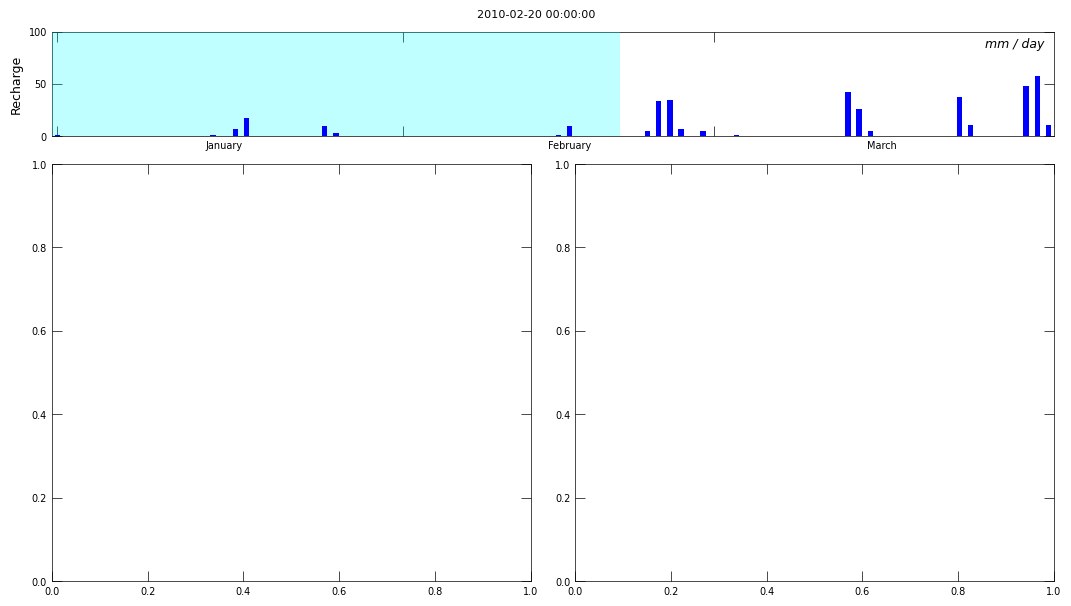

In [58]:
totim = 50
npz_idx = sampled_time_keys[totim]
with styles.USGSMap():
    fig, axd = plt.subplot_mosaic(
    mosaic_list,
    layout="constrained", 
    figsize=figsize,
    )    

    ax = axd["c"]
    ax.set_xlim(-0.5,mean_recharge.shape[0]-.5)
    ax.set_ylim(rch_min, rch_max)

    df.plot(kind="bar", ax=ax, legend=False, zorder=111, color="blue")
    fb = ax.fill_between([-0.5, totim+0.5], rch_max, **progress_kwds)

    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%B'))
    
    # Remove the tick lines
    ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment('center')

    ax.set_ylabel("Recharge")
    styles.add_text(ax, text=f"{units} / day", x=0.99, y=0.95, bold=False, va="top", ha="right")
    
    title_str = set_title_string(time_mf[int(totim)])
    fig.suptitle(title_str, fontsize=8)

    bh = ghb_elev[str(npz_idx)] * head_conversion_factor
    h = hobj.get_ts(head_idx)[int(totim), 1:] * head_conversion_factor
    hd = h - bh
    
    cnd = ghb_cond[str(npz_idx)]
    mask = cnd == 0.0
    
    bh[mask] = np.nan
    hd[mask] = np.nan
    cnd[mask] = np.nan
    
    ax = axd["a"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    mf6_gpd.plot(ax=ax, alpha=alpha, column="bhead", lw=0.25, ec="black", vmin=stage_min, vmax=stage_max)
    v = ax.collections[0]
    v.set_array(bh)
    plt.colorbar(v, ax=ax, shrink=0.5, extend="both", orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)

    ax.set_title(f"Stage ({stage_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # coastal model inset
    ax_ins = axd["a"].inset_axes(
        [-0.125, 0.55, 0.45, 0.45],
        xticklabels=[], 
        yticklabels=[],
    )
    wdp = stage.isel(time=time_index[totim]).ugrid.plot(animated=True, ax=ax_ins, vmin=stage_min, vmax=stage_max, lw=0.0, alpha=0.25, add_colorbar=False)
    gdfp = coastal_gdf.plot(color="black", fc="none", lw=0.25, ax=ax_ins)
    wdp.set_array(mask_stage(totim))

    ax_ins.set_xlim(extent[:2])
    ax_ins.set_ylim(extent[2:])
    cx.add_basemap(ax_ins, crs=gp_gpd.crs, attribution=False, source=cx_provider, zoom=11)

    ax_ins.set_title(f"DFLOW Stage ({stage_units})", size=8)
    ax_ins.set_xlabel(None)
    ax_ins.set_ylabel(None)
    ax_ins.set_xticklabels([])
    ax_ins.set_yticklabels([])    

    ax = axd["b"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    # mf6_gpd.plot(ax=ax, alpha=alpha, column="cond", lw=0.25, ec="black")
    mf6_gpd.plot(ax=ax, alpha=alpha, column="head_difference", lw=0.25, ec="black")
    v = ax.collections[0]
    # v.set_array(cnd)
    v.set_array(hd)
    plt.colorbar(v, ax=ax, shrink=0.5, orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Head difference ({head_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    fig.align_labels()    

    fig.savefig(f"figures/greenport_modflow_dflow_ghb{fig_ext}", dpi=300, transparent=transparent)

#### Animate GHB data

In [ ]:
with styles.USGSMap():
    fig, axd = plt.subplot_mosaic(
        mosaic_list,
        layout="constrained",
        figsize=figsize,
    )    

    ax = axd["c"]
    ax.set_xlim(-0.5,mean_recharge.shape[0]-.5)
    ax.set_ylim(rch_min, rch_max)

    df.plot(kind="bar", ax=ax, legend=False, zorder=111, color="blue")
    fb = ax.fill_between([-0.5, -0.5], rch_max, **progress_kwds)

    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%B'))
    
    # Remove the tick lines
    ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment('center')

    ax.set_ylabel("Recharge")
    styles.add_text(ax, text=f"{units} / day", x=0.99, y=0.95, bold=False, va="top", ha="right")    

    title_str = set_title_string(time_mf[0])
    fig.suptitle(title_str, fontsize=8)

    ax = axd["a"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    mf6_gpd.plot(ax=ax, alpha=alpha, column="bhead", lw=0.5, ec="black", vmin=stage_min, vmax=stage_max)
    plt.colorbar(ax.collections[0], ax=ax, shrink=0.5, extend="both", orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Coastal stage ({stage_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax = axd["b"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    mf6_gpd.plot(ax=ax, alpha=alpha, column="head_difference", lw=0.25, ec="black")
    plt.colorbar(ax.collections[0], ax=ax, shrink=0.5, orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Head difference ({stage_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # coastal model inset
    ax_ins = axd["a"].inset_axes(
        [-0.125, 0.55, 0.45, 0.45],
        xticklabels=[], yticklabels=[],
    )
    wdp = stage.isel(time=time_index[0]).ugrid.plot(animated=True, ax=ax_ins, vmin=stage_min, vmax=stage_max, lw=0.0, alpha=0.25, add_colorbar=False)
    gdfp = coastal_gdf.plot(color="black", fc="none", lw=0.25, ax=ax_ins)
    wdp.set_array(mask_stage(0))
    
    ax_ins.set_title(f"DFLOW Stage ({stage_units})", size=8)
    ax_ins.set_xlim(extent[0:2])
    ax_ins.set_ylim(extent[2:])
    ax_ins.set_xlabel(None)
    ax_ins.set_ylabel(None)

    cx.add_basemap(ax_ins, crs=gp_gpd.crs, attribution=False, source=cx_provider, zoom=11)

    fig.align_labels()
    
    def func(idx):
        global fb, wdp
        
        ax = axd["c"]
        fb.remove()
        fb = ax.fill_between([-0.5, float(idx)+0.5], rch_max, **progress_kwds)
        
        on_time = set_title_string(time_mf[idx])
        fig.suptitle(on_time, fontsize=8)
        
        bh = ghb_elev[str(sampled_time_keys[idx])] * head_conversion_factor
        h = hobj.get_ts(head_idx)[idx, 1:] * head_conversion_factor
        hd = h - bh
        
        cnd = ghb_cond[str(sampled_time_keys[idx])]
        idx_map = (cnd == 0.)
        
        bh[idx_map] = np.nan
        hd[idx_map] = np.nan
        
        ax = axd["a"]
        ax.collections[0].set_array(bh)
        
        ax = axd["b"]
        ax.collections[0].set_array(hd)

        wdp.set_array(mask_stage(idx))
        
        return fb, wdp

    ani = FuncAnimation(fig, func, frames=frames, blit=False)
    
    plt.close()

ani.save(animation_ws / f"greenport_modflow_dflow_ghb{ani_ext}", writer=writer)
# HTML(ani.to_jshtml())